In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
%matplotlib inline
import matplotlib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

C:\Users\deera\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_data(file_name):
    df = pd.read_csv(file_name)
    return df

In [3]:
train = read_data('train.csv')
test = read_data('test.csv')
test_ids = test['Id']
print(train.shape, test.shape)

(1460, 81) (1459, 80)


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
all_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [5]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [6]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [7]:
# MSSubClass는 숫자지만 category로 봐야함
all_data['MSSubClass'] = all_data['MSSubClass'].astype('object')

In [8]:
# 숫자가 아닌 column 처리
all_data = pd.get_dummies(all_data)

In [9]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [10]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

## Ridge regression (L2 regularization) 

In [11]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [12]:
model_ridge = Ridge()

In [13]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

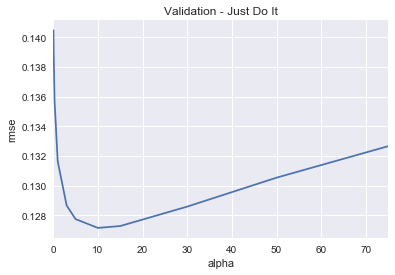

In [14]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [15]:
cv_ridge.min()

0.1271568213107023

## Lasso regression (L1 regularization)

In [16]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001]).fit(X_train, y)

In [17]:
rmse_cv(model_lasso).mean()

0.12412226710399703

Lasso의 RMSE가 Ridge보다 작음!

In [18]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [19]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 80 variables and eliminated the other 223 variables


In [20]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

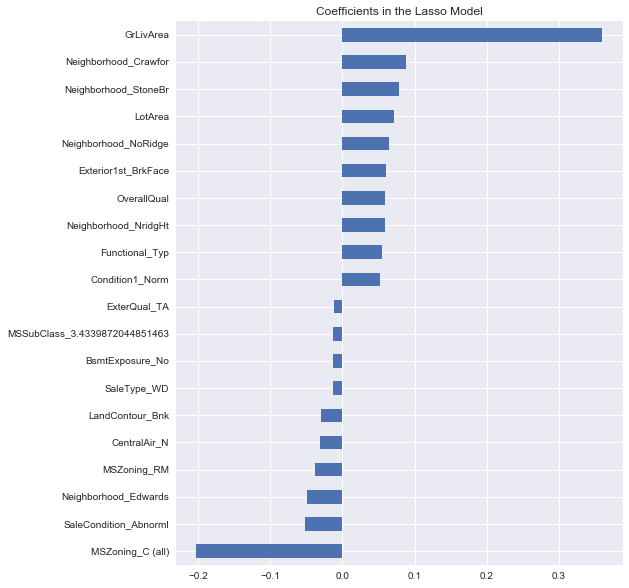

In [21]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

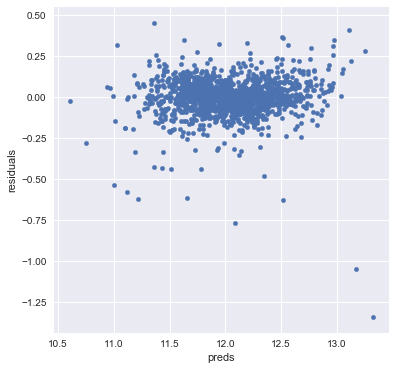

In [22]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## Adding an xgboost model

In [23]:
# import xgboost as xgb

In [24]:
# dtrain = xgb.DMatrix(X_train, label = y)
# dtest = xgb.DMatrix(X_test)

# params = {"max_depth":2, "eta":0.1}
# model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [25]:
lasso_preds = np.expm1(model_lasso.predict(X_test))
# lasso_preds = model_lasso.predict(X_test)

In [26]:
# preds = 0.7*lasso_preds + 0.3*xgb_preds
preds = 1.0*lasso_preds

In [27]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("output.csv", index = False)

## Elastic Net Regression

In [28]:
from mpl_toolkits.mplot3d import Axes3D

alphas = [0.001, 0.01, 0.05, 0.1, 0.3, 1]
l1 = [1, 0.1, 0.001, 0.0005]
assembles = [(a, b) for b in l1 for a in alphas]
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha, l1_ratio=l1)).mean() 
            for alpha, l1 in assembles]

In [29]:
inputs = pd.DataFrame(assembles, columns=['alpha', 'l1'])
inputs['rmse'] = cv_elastic
inputs.sort_values('rmse')[:3]

,alpha,l1,rmse
0,0.001,1.000,0.124122
6,0.001,0.100,0.126436
13,0.010,0.001,0.127060


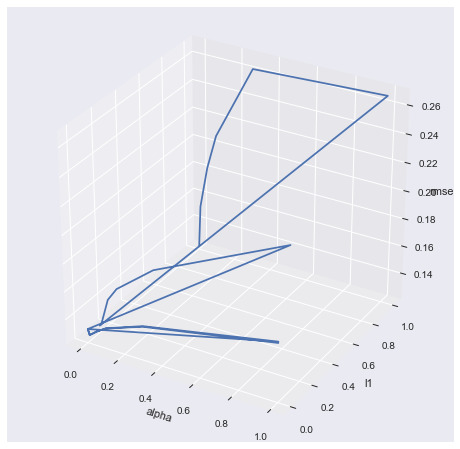

In [30]:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
threedee = plt.figure().gca(projection='3d')
threedee.plot(inputs['alpha'], inputs['l1'], inputs['rmse'])
threedee.set_xlabel('alpha')
threedee.set_ylabel('l1')
threedee.set_zlabel('rmse')
plt.show()

In [31]:
model_elastic = ElasticNet(alpha = 0.005, l1_ratio = 0.1).fit(X_train, y)

In [32]:
rmse_cv(model_elastic).mean()

0.12480924139681118

In [33]:
elastic_preds = np.expm1(model_elastic.predict(X_test))

In [34]:
elastic_solution = pd.DataFrame({"id":test.Id, "SalePrice":elastic_preds})
elastic_solution.to_csv("elastic_output.csv", index = False)

In [35]:
solution[solution['SalePrice'] == 0]

,SalePrice,id
